## Kalman control of a Wilson Cowan system 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, block_diag
import ipywidgets as widgets
from tqdm import tqdm 
# Unscented Kalman Filter (UKF) applied to FitzHugh-Nagumo neuron dynamics.

### Wilson-Cowan model 

we use the equations (like 6.7 in the book) in the form used in 
 Schiff SJ, Sauer T. Kalman filter control of a model of spatiotemporal cortical dynamics. J Neural Eng. 2008 Mar 15;5(1):1–8. 


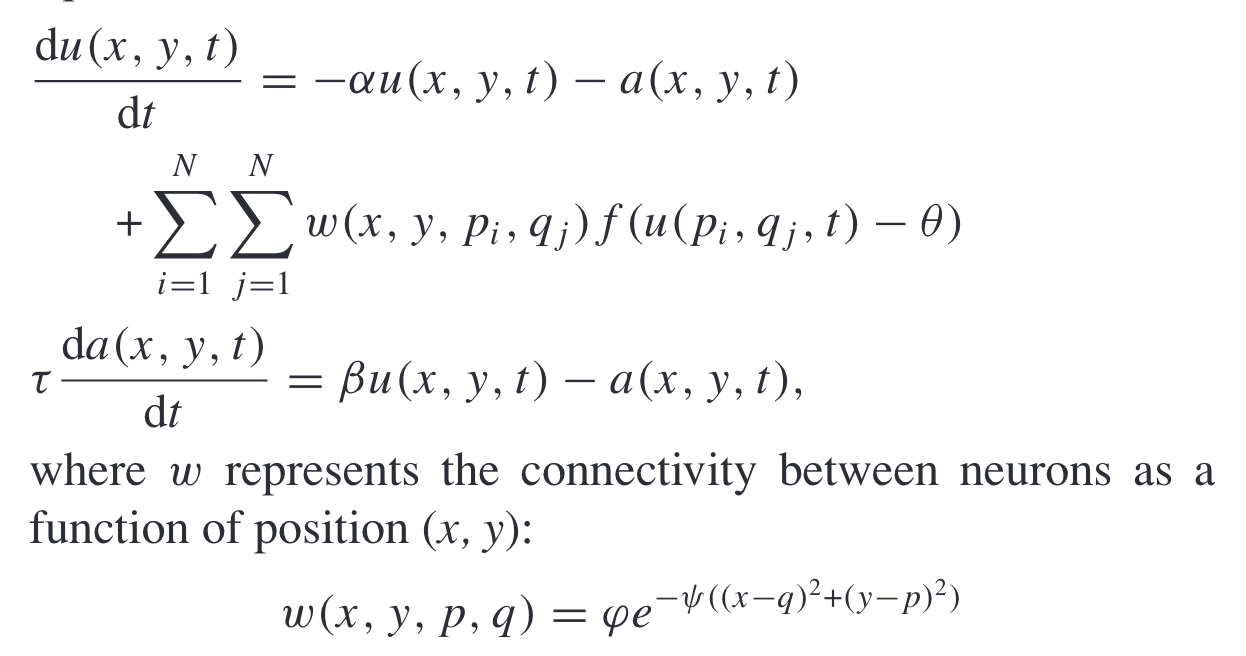

# Define parameters


In [10]:
q = 2  # or any value up to 12 
Threshold = 0.1  # firing threshold 
numsteps = 200  # number of iterations
B = 1000 # beta in the equations above
C = 15 # inverse time constant for u (\alpha in the equations above)
g = 8  # number of columns in the grid
f = 8  # number of rows in the grid
K = 10  # input gain for u (\phi in equations above) 
k = 0.05  # inverse spread of connectivity (\psi # beta in the equations abovein the equations abovce) 
dt = 0.001  # integration interval 
tau = 0.01  # time constant for a 

In [11]:
# Initial conditions for u and a


u0 = np.array([
    [-0.1637, -0.2244, -0.1982, -0.1410, -0.1029, -0.0811, -0.0656, -0.0396],
    [-0.2593, -0.3580, -0.3021, -0.2008, -0.1321, -0.1028, -0.0840, -0.0516],
    [-0.2444, -0.3386, -0.2746, -0.1726, -0.0950, -0.0742, -0.0637, -0.0417],
    [-0.0055, -0.0383, 0.0012, -0.0657, -0.0395, -0.0388, -0.0387, -0.0270],
    [0.2361, 0.3685, 0.2616, 0.2237, 0.0279, -0.0174, -0.0239, -0.0183],
    [0.4698, 0.7002, 0.5627, 0.2726, 0.0939, -0.0071, -0.0171, -0.0135],
    [0.3618, 0.5613, 0.4323, 0.2754, 0.0673, -0.0056, -0.0130, -0.0104],
    [0.2442, 0.2669, 0.2571, 0.1067, 0.0152, -0.0049, -0.0077, -0.0061]
])

a0 = np.array([
    [0.4104, 0.5339, 0.4345, 0.2786, 0.1904, 0.1454, 0.1157, 0.0694],
    [0.7058, 0.9183, 0.6974, 0.4049, 0.2427, 0.1821, 0.1465, 0.0893],
    [0.9263, 1.1846, 0.8515, 0.4104, 0.1757, 0.1283, 0.1085, 0.0707],
    [1.0750, 1.4204, 1.0146, 0.4695, 0.0921, 0.0646, 0.0636, 0.0444],
    [1.0367, 1.4612, 0.9507, 0.4993, 0.0532, 0.0309, 0.0380, 0.0293],
    [0.7878, 1.1079, 0.7914, 0.3707, 0.0468, 0.0205, 0.0267, 0.0213],
    [0.4156, 0.5573, 0.4218, 0.1886, 0.0255, 0.0150, 0.0202, 0.0162],
    [0.1386, 0.1823, 0.1406, 0.0437, 0.0083, 0.0090, 0.0119, 0.0095]
])

n, p = u0.shape

### Function definition 

In [12]:
def kalmanwc_obs(x,dq):
    # we only observe the u's, not the recovery variables, just like the FN case 
    r = x[dq:f*g+dq]
    return r

In [13]:
def fc(x, p1):
    Rows, Columns = x.shape
    w = np.zeros((Rows, Columns))

    for NumberOfColumns in range(Columns):
        u = x[0:f*g, NumberOfColumns].reshape((f, g))
        a = x[f*g:2*f*g, NumberOfColumns].reshape((f, g))
        q = 2
        # we are estimating only the threshold
        # vector p looks like this: p=[K,C,B,tau,z]
        p = np.concatenate(([1.38, 3, 10, 4.85], p1[:, NumberOfColumns]))

        # ue = np.concatenate((np.zeros((g, q)), u, np.zeros((g, q))), axis=1)
        # ue = np.concatenate((np.zeros((q, f + 2 * q)), ue, np.zeros((q, f + 2 * q))), axis=0)
        ue = np.pad(u, ((q, q), (q, q)), mode='constant')
        integ = np.zeros((f, g))

        for i in range(-q, q + 1):
            for j in range(-q, q + 1):
                integ += p[0] * np.exp(-k * (i**2 + j**2)) * (ue[i+q:i+f+q, j+q:j+g+q] > p[4])

        integ -= p[0] * (u > p[4])
        udot = (-p[1] * u - a + integ)
        adot = (p[2] * u - a) / p[3]
        w[:, NumberOfColumns] = np.concatenate([udot.flatten(), adot.flatten()])

    return w


In [14]:
def kalmanwc_fct(dq, x):
  
    dT = nn * dt
    p = x[:dq, :]  # strips out p from first row
    xn = x[dq:, :]

    for n in range(1, nn + 1):
        k1 = dt * fc(xn, p)
        k2 = dt * fc(xn + k1 / 2, p)
        k3 = dt * fc(xn + k2 / 2, p)
        k4 = dt * fc(xn + k3, p)
        xn = xn + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6

    r = np.vstack([p, xn])  # returns original p
    return r



In [15]:
def kalmanwc_int(x, z):
    
    u = np.reshape(x[:f * g], (f, g))
    a = np.reshape(x[f * g:2 * f * g], (f, g))

    p = [K, C, B, tau, z]
    ue = np.concatenate((np.zeros((g, q)), u, np.zeros((g, q))), axis=1)
    ue = np.concatenate((np.zeros((q, f + 2 * q)), ue, np.zeros((q, f + 2 * q))), axis=0)

    integ = np.zeros((f, g))
    for i in range(-q, q + 1):
        for j in range(-q, q + 1):
            integ += p[0] * np.exp(-k * (i**2 + j**2)) * (ue[i+q:i+f+q, j+q:j+g+q] > p[4])

    integ -= p[0] * (u > p[4])
    udot = (-p[1] * u - a + integ)
    adot = (p[2] * u - a) / p[3]
    r = np.concatenate((udot.flatten(), adot.flatten()))

    return r


In [16]:
# Unscented transformation. Not specific to FitzHugh-Nagumo model
def kalmanwc_ut(xhat, Pxx, y, fct, obsfct, dq, dx, dy, R):

    N = 2 * dx
    
    xsigma = sqrtm(dx * Pxx).T  # Pxx = root * root', but Pxx = chol' * chol
    Xa = xhat[:, np.newaxis] + np.hstack([xsigma, -xsigma])
    X = fct(dq, Xa)

    xtilde = np.mean(X, axis=1)  # same as xtilde = np.sum(X, axis=1) / N

    Pxx = np.zeros((dx, dx))
    for i in range(N):
        Pxx += np.outer((X[:, i] - xtilde), (X[:, i] - xtilde)) / N

    Y = np.atleast_2d(obsfct(X, dq))

    ytilde = np.mean(Y, axis=1)
    Pyy = R.copy()
    for i in range(N):
        Pyy += np.outer((Y[:, i] - ytilde), (Y[:, i] - ytilde)) / N

    Pxy = np.zeros((dx, dy))
    for i in range(N):
        Pxy += np.outer((X[:, i] - xtilde), (Y[:, i] - ytilde)) / N

    K = np.dot(Pxy, np.linalg.inv(Pyy))  # same as K = np.dot(Pxy, np.linalg.inv(Pyy))
    xhat = xtilde + np.dot(K, (y - ytilde))
    Pxx = Pxx - np.dot(K, Pxy.T)

    Pxx = (Pxx + Pxx.T) / 2. + ip * np.eye(Pxx.shape[0]) # covariance inflation

    return xhat, Pxx, K

## Define parameters

In [17]:

# ***SELECT the Gain, NoiseFactor, to reproduce calculations in paper
NoiseFactor = 10
EnergyPlotYAxis = 0.00004

# n.b.: increasing negative gain will quench the waves
# For instance, try Gain=-0.05 to see this clearly.
# p=[K,C,B,tau,Threshold]
K = 1.38 # input gain for u (\phi in equations above)
C = 3 # inverse time constant for u (\alpha in the equations above) 
B = 10 # beta in the equations above
tau = 4.85 # time constant for a
k = 0.91  # inverse spread of connectivity (\psi in the equations above)
# 5 parameters plus 2 variables each cell

# Dimension of Grid
f = 8
g = f
,
# Dimensions: (dq for param. vector, dx augmented state, dy observation)
dq = 1
dx = dq + 2 * f * g
dy = f * g
fct = kalmanwc_fct  # this is the model function F(x) used in filtering
obsfct = kalmanwc_obs  # this is the observation function G(x)

N = 500  # number of data samples
dt = 0.06
nn = 1
dT = nn * dt  # Step size dt
MaxPlotEnergy = np.finfo(float).eps
ControlTime = 40
EnergyThreshold = 4
ip = 0.0001

### Main loop

In [ ]:
for WithControl in (1,2):
    if WithControl == 1:
        Gain = 0  # get baseline # use with noise 10 - shows advantage of Kalman Observer
    else:
        Gain = -0.0006  # can set this + or -

    # Initial conditions for estimation
    MSEsum = 0  # initialize
    uEnergy_y_sum = 0
    uEnergy_yhat_sum = 0

    u = u0
    a = a0
    x0 = np.zeros((2*f*g,N))
    x = np.zeros((2*f*g+1,N))

    x0[:,0] = np.concatenate((u.flatten(), a.flatten()))

    # External input, estimated as parameter p(5) later on:
    z = np.ones((1,N)) * 0.24
    x[:,0] = np.concatenate((z[:,0], x0[:,0]))

    t = 0  # initialize
    xhat= np.zeros(x.shape)
    xhat[:,0] = x[:, 0]  # first guess of x_1 set to observation
    xhat[0, 0] = 0.55  # set first guess of first parameter arbitrarily
    yhat = np.zeros((dy,N))
    yhat[:,0] = xhat[dq:dq+f*g, 0]

    Q = 0.0001  # process noise covariance matrix
    errors = np.zeros((dx, N))
    Energy = np.zeros(N)
    Energy_y = np.zeros(N)
    Energy_yhat = np.zeros(N)
    uEnergy_yhat = np.zeros((N,))

    tempx = x[:, :1] * np.ones((1, N))
    if t > 1:
        R = 0.2**2 * np.cov(kalmanwc_obs(tempx[:, :N], dq))  # observation noise cov matrix
    else:
        R = np.zeros((f*g, f*g))
    R = R + np.finfo(float).eps * np.eye(R.shape[0])
    Pxx = block_diag(Q, R, R) 
    
    np.random.seed(3)
    y = np.zeros((dy, N))
    y[:,0] = obsfct(x[:, 0], dq) + (sqrtm(R) @ np.random.randn(dy, 1)).ravel()  # noisy data
    np.random.seed(0)  # Not using this - set state above
    Energy_y[0] = np.sum(y[:, t] ** 2)  # y
    Energy_yhat[0] = np.sum(yhat[:, t] ** 2)  # y
    
    for t in tqdm(range(1, N)):
        xx = x0[:, t - 1]  # Pick column (at start, only 1 column of initial conditions)
        if t >= ControlTime:
            uVector_yhat = Gain * yhat[:, t - 1]
            uEnergy_yhat[t] = uVector_yhat.T @ uVector_yhat
            ControlVector_yhat = np.concatenate([uVector_yhat, np.zeros((f * g,))])
            xx = xx + ControlVector_yhat
            xhat[:, t - 1] = xhat[:, t - 1] + np.concatenate([np.array((0,)), ControlVector_yhat])
        else:
            uEnergy_yhat[t] = 0  # no control yet

        for i in range(nn):  # nn determines how many times to loop the RK - can use 1
            k1 = dt * kalmanwc_int(xx, z[:, t - 1])  # feed a col of x and a value of z
            k2 = dt * kalmanwc_int(xx + k1 / 2, z[:, t - 1])
            k3 = dt * kalmanwc_int(xx + k2 / 2, z[:, t - 1])
            k4 = dt * kalmanwc_int(xx + k3, z[:, t - 1])
            xx = xx + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6

        x0[:, t] = xx
        x[:,t] = np.concatenate([z[:,t], x0[:,t]])  # augmented state vector
        if t > 1:
            R = 0.2**2 * np.cov(kalmanwc_obs(x[:, :t], dq))  # observation noise cov matrix
        else:
            R = np.zeros((f*g,f*g))
        R = R + np.finfo(float).eps * np.eye(R.shape[0])
        y[:,t] = obsfct(x[:,t], dq) + NoiseFactor * (sqrtm(R) @ np.random.randn(dy, 1)).ravel()  # noisy data
        xhat[:, t], Pxx, kalman_gain = kalmanwc_ut(xhat[:, t - 1], Pxx, y[:, t], fct, obsfct, dq, dx, dy, R)
        Pxx[0, 0] = max(Pxx[0, 0], Q)  # keep the parameter cov from fading to 0
        yhat[:, t] = xhat[dq:dq + f * g, t]
        Energy_y[t] = np.sum(y[:, t] ** 2)  # the rms at time t
        Energy_yhat[t] = np.sum(yhat[:, t] ** 2)  # y
        errors[:, t] = np.sqrt(np.diag(Pxx[:, :]))

 32%|████████████▌                          | 161/499 [01:40<03:52,  1.46it/s]

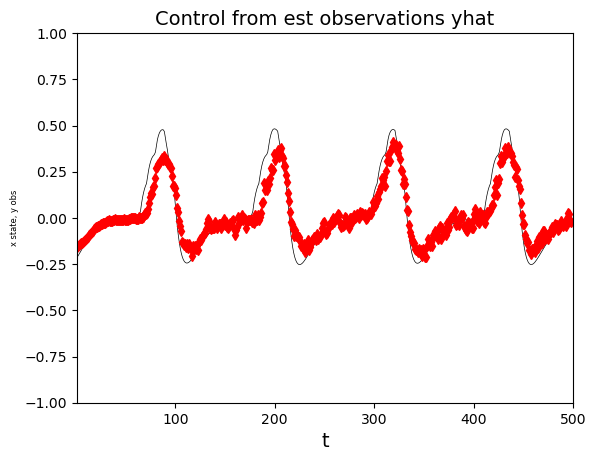

In [159]:
plt.plot(x[dq + 1, :t].T, 'k', linewidth=0.5)
if Gain == 0:
    plt.plot(y[0, :t].T, 'bd', markeredgecolor='blue', markerfacecolor='blue', markersize=5)
else:
    plt.plot(yhat[0, :t].T, 'rd', markeredgecolor='red', markerfacecolor='red', markersize=5)
plt.xlabel('t', fontsize=14)
plt.axis([1, N, -1, 1])
plt.title('Control from est observations yhat', fontsize=14)
plt.ylabel('x state, y obs', fontsize=6)
plt.draw()

Text(0, 0.5, 'a, est a')

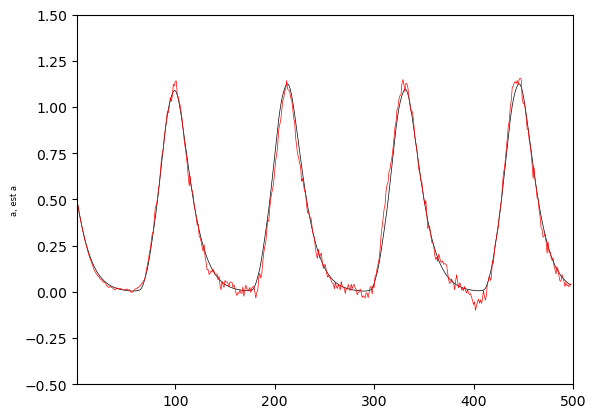

In [162]:
plt.plot(x[dy + 2, :t].T, 'k', linewidth=0.5)  # unobserved variable
plt.plot(xhat[dy + 2, :t].T, 'r', linewidth=0.5)  # est unobserved variable
plt.axis([1, N, -0.5, 1.5])
plt.ylabel('a, est a', fontsize=6)

Text(0, 0.5, "['thr', ', ', ' est ', 'thr']")

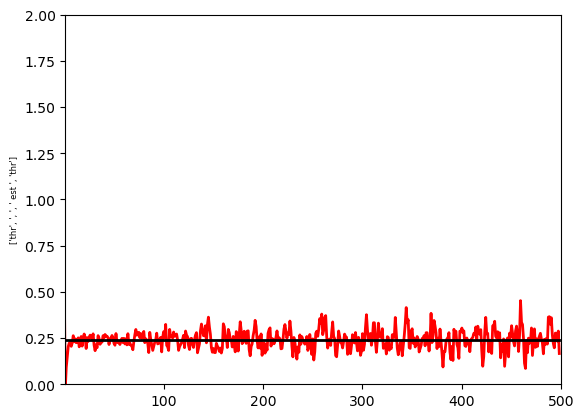

In [163]:
plt.plot(xhat[0, :t], 'r', linewidth=2)
plt.plot(x[0, :t], 'k', linewidth=2)  # parameter
plt.axis([1, N, 0, 2.0])
plt.ylabel(['thr', ', ', ' est ', 'thr'], fontsize=6)

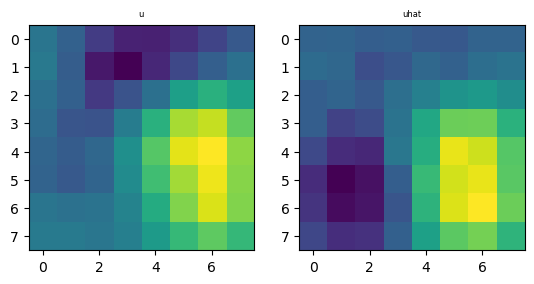

In [166]:
plt.subplot(121)
u = np.reshape(y[:, t], (f, g))  # Display noisy observations
plt.imshow(u)
plt.title('u', fontsize=6)
#plt.axis([0, f, 0, g, -1.5, 1.5])
plt.subplot(122)
uhat = np.reshape(xhat[dq:f * g + dq, t], (f, g))
plt.imshow(uhat)
plt.title('uhat', fontsize=6)
#plt.axis([0, f, 0, g, -1.5, 1.5])
plt.draw()


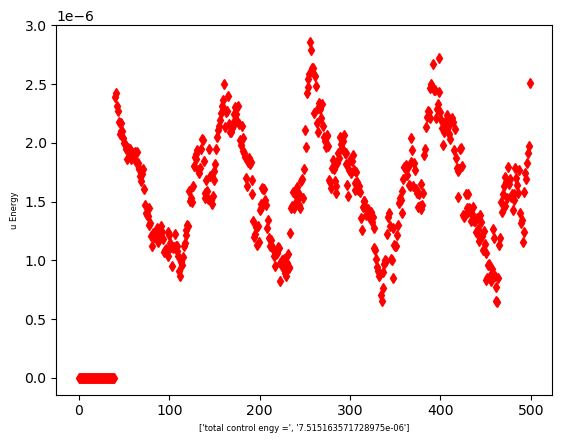

In [169]:
if t > ControlTime:
    if uEnergy_yhat[t] > MaxPlotEnergy:
        MaxPlotEnergy = uEnergy_yhat[t]  # store max graph value
    uEnergy_yhat_sum = uEnergy_yhat_sum + uEnergy_yhat[t]
    if Gain == 0:
        plt.plot(uEnergy_yhat, 'bd', markeredgecolor='blue', markerfacecolor='blue', markersize=5)
    else:
        plt.plot(uEnergy_yhat, 'rd', markeredgecolor='red', markerfacecolor='red', markersize=5)

    plt.xlabel(['total control engy =', str(uEnergy_yhat_sum)], fontsize=6)
    plt.ylabel('u Energy', fontsize=6)
    #plt.axis([1, N, 0, MaxPlotEnergy])

#plt.show()

In [180]:
@widgets.interact(i=(0,N-1))
def img_render(i=0):
    plt.subplot(131)
    u_real= np.reshape(x[dq:f * g + dq, i], (f, g))
    plt.imshow(u_real)
    plt.title('Real u', fontsize=6)
    plt.clim(0, y.max()/2)
    plt.subplot(132)
    u = np.reshape(y[:, i], (f, g))  # Display noisy observations
    plt.imshow(u)
    plt.title('Observed u', fontsize=6)
    plt.clim(0, y.max()/2)
    #plt.axis([0, f, 0, g, -1.5, 1.5])
    plt.subplot(133)
    uhat = np.reshape(xhat[dq:f * g + dq, i], (f, g))
    plt.imshow(uhat)
    plt.title('uhat', fontsize=6)
    plt.clim(0, y.max()/2)
    #plt.axis([0, f, 0, g, -1.5, 1.5])


interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

In [179]:
@widgets.interact(i=(0,N-1))
def img_render(i=0):
    u_real= np.reshape(x[dq:f * g + dq, i], (f, g))
    plt.imshow(u_real)
    plt.title('Real u', fontsize=6)
    plt.clim(0, y.max())

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

(64, 500)